**Module Name and Number:** CASA0013: Introduction to Programming for Spatial Analysts 

**Student ID:** 20022308

**Title:** The differential impact on London's boroughs imposed by Airbnb

**Word Count (for the Executive Briefing):** 1371(4 figures)


# Reproducible Analysis

In [489]:
import geopandas as gpd
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### 1.Reading data

#### 1.1 Boundary data

D:\GIS\anaconda3\envs\sds2020\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

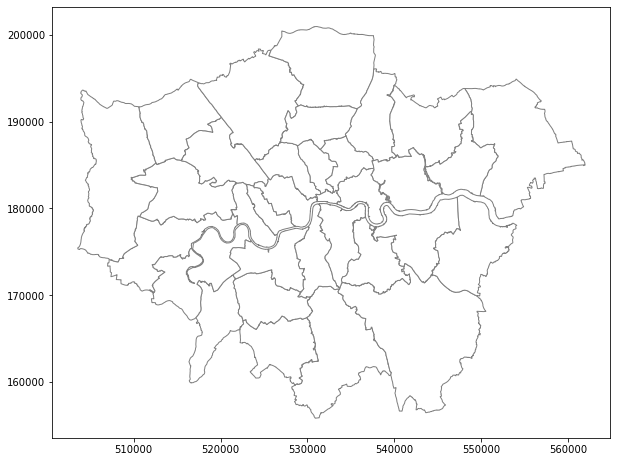

In [490]:
# unzip Boundary data
import gzip
import os
def un_gz(file_name):
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "wb+").write(g_file.read())
    g_file.close() 
un_gz('Boroughs.gpkg.gz')

# read Boundary data
wards=gpd.read_file('Boroughs.gpkg')
wards.plot(facecolor="white",edgecolor="gray",figsize=(10,8))

In [491]:
#check the crs
print(wards.crs)

epsg:27700


In [492]:
wards=wards.to_crs('epsg:4326')

#### 1.2 Airbnb Data
Source: [InsideAirbnb](http://insideairbnb.com/get-the-data.html)

Three data sets used in this report is collected on _04 March 2017_, _07 December 2018_ and _09 December 2019_.




In [493]:
airbnb2017=pd.read_csv('airbnb2017.csv.gz',compression='gzip',low_memory=False)
airbnb2018=pd.read_csv('airbnb2018.csv.gz',compression='gzip',low_memory=False)
airbnb2019=pd.read_csv('airbnb2019.csv.gz',compression='gzip',low_memory=False)

#### 1.3 Average Private Rents
This is the data of the numbers and prices of private rents in 2017, 2018 and 2019 collected by Valuation Office Agency.

Detailed infomation and the data set are avaliable on [this page](https://data.london.gov.uk/dataset/average-private-rents-borough) of the London Data Store.

In [494]:
voa=pd.read_csv(f'voa-average-rent-borough.csv.gz',compression='gzip')
voa.head()

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
0,2011,Q2,E09000001,City of London,Room,-,-,-,-,-
1,2011,Q2,E09000002,Barking and Dagenham,Room,92,336,282,347,390
2,2011,Q2,E09000003,Barnet,Room,945,450,399,433,500
3,2011,Q2,E09000004,Bexley,Room,119,390,347,390,433
4,2011,Q2,E09000005,Brent,Room,344,469,390,457,550


### 2.Clean Data
#### 2.1 Airbnb listings in 2017, 2018, and 2019

In [495]:
#check the null id
for i in [airbnb2017,airbnb2018,airbnb2019]:
    print(f'The number of null id:{i[i.id.isna()].shape[0]}')

The number of null id:0
The number of null id:0
The number of null id:0


<AxesSubplot:ylabel='Frequency'>

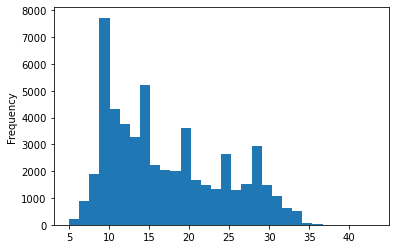

In [496]:
#check the null by row
# first, 2017
airbnb2017.isnull().sum(axis=1).plot.hist(bins=30) 

In [497]:
#delete problematic rows
airbnb2017_clean=airbnb2017.drop(airbnb2017.isnull().sum(axis=1)[airbnb2017.isnull().sum(axis=1) > 15].index)

<AxesSubplot:ylabel='Frequency'>

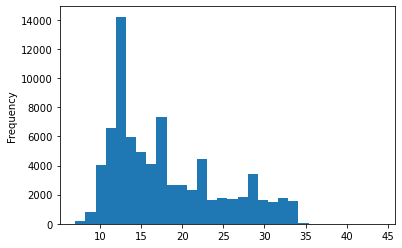

In [498]:
# then, do the same to 2018
airbnb2018.isnull().sum(axis=1).plot.hist(bins=30) 

In [499]:
airbnb2018_clean=airbnb2018.drop(airbnb2018.isnull().sum(axis=1)[airbnb2018.isnull().sum(axis=1) > 17].index)

<AxesSubplot:ylabel='Frequency'>

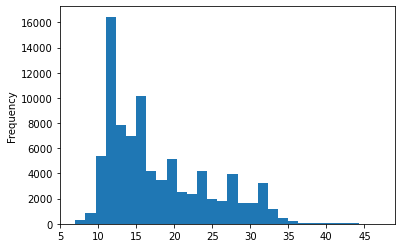

In [500]:
# last, 2019
airbnb2019.isnull().sum(axis=1).plot.hist(bins=30) 

In [501]:
airbnb2019_clean=airbnb2019.drop(airbnb2019.isnull().sum(axis=1)[airbnb2019.isnull().sum(axis=1) > 16].index)

In [502]:
# check the size of cleaded data
a=2017
print(f'After cleaning:')
for i in [airbnb2017_clean,airbnb2018_clean,airbnb2019_clean]:
    print(f'Airbnb data sets in {a} becomes {i.shape[0]} X {i.shape[1]}')
    a=a+1

After cleaning:
Airbnb data sets in 2017 becomes 27305 X 95
Airbnb data sets in 2018 becomes 44680 X 96
Airbnb data sets in 2019 becomes 48011 X 106


In [503]:
# then, transit these data into the point based on their coordinate
point2017=gpd.GeoDataFrame(airbnb2017_clean, geometry=gpd.points_from_xy(airbnb2017_clean['longitude'],airbnb2017_clean['latitude'],crs='epsg:4326'))
point2018=gpd.GeoDataFrame(airbnb2018_clean, geometry=gpd.points_from_xy(airbnb2018_clean['longitude'],airbnb2018_clean['latitude'],crs='epsg:4326'))
point2019=gpd.GeoDataFrame(airbnb2019_clean, geometry=gpd.points_from_xy(airbnb2019_clean['longitude'],airbnb2019_clean['latitude'],crs='epsg:4326'))

In [504]:
# Write them to local directory as shp (this may take a while!)
import pyproj
!mkdir airbnb_point
point2017.to_file(r'airbnb_point/point2017.shp',driver='ESRI Shapefile',encoding='utf-8')
point2018.to_file(r'airbnb_point/point2018.shp',driver='ESRI Shapefile',encoding='utf-8')
point2019.to_file(r'airbnb_point/point2019.shp',driver='ESRI Shapefile',encoding='utf-8')

#### 2.2 Average Private Rents data

In [505]:
voa[voa.Code.isna()]

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile


In [506]:
voa.isnull().sum(axis=1).sort_values(ascending=False)

0       0
4043    0
4113    0
4112    0
4111    0
       ..
2050    0
2049    0
2048    0
2047    0
6159    0
Length: 6160, dtype: int64

In [507]:
voa2017=voa[voa.Year==2017][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2017','Count of rents':'Count_2017'})
voa2018=voa[voa.Year==2018][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2018','Count of rents':'Count_2018'})
voa2019=voa[voa.Year==2019][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2019','Count of rents':'Count_2019'})

<ipython-input-507-d374859a0250>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  voa2017=voa[voa.Year==2017][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2017','Count of rents':'Count_2017'})
<ipython-input-507-d374859a0250>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  voa2018=voa[voa.Year==2018][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2018','Count of rents':'Count_2018'})
<ipython-input-507-d374859a0250>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  voa2019=voa[voa.Year==2019][voa.Category=='All categories'][['Code','Count of rents','Average']].rename(columns={'Average':'Average_2019','Count of rents':'Count_2019'})


### 3.Pre-process data

#### 3.1 Count the numbers of airbnb of each boroughs

In [508]:
# read the shapefiles for counting
point2017_shp=gpd.read_file('airbnb_point/point2017.shp')
point2018_shp=gpd.read_file('airbnb_point/point2018.shp')
point2019_shp=gpd.read_file('airbnb_point/point2019.shp')

In [509]:
#count the points(it may take a while cuz there are too many points)
num2017=pd.DataFrame({'GSS_CODE':[],'counts_airbnb_2017':[]})
num2017.GSS_CODE=wards.GSS_CODE
for i in range(0,  len(wards)): 
    num2017.counts_airbnb_2017[i]=0
    for j in range(0, len(point2017_shp)):
        if point2017_shp.geometry[j].intersects(wards.geometry[i]):num2017.counts_airbnb_2017[i]=num2017.counts_airbnb_2017[i]+1
wards_merge = wards.merge(num2017,on='GSS_CODE', how = 'left')

<ipython-input-509-b0430f58f91e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num2017.counts_airbnb_2017[i]=0
<ipython-input-509-b0430f58f91e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if point2017_shp.geometry[j].intersects(wards.geometry[i]):num2017.counts_airbnb_2017[i]=num2017.counts_airbnb_2017[i]+1


In [510]:
#check if it is successful
wards_merge.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,counts_airbnb_2017
0,Kingston upon Thames,E09000021,3726.117,0.000,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0
1,Croydon,E09000008,8649.441,0.000,F,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",242.0
2,Bromley,E09000006,15013.487,0.000,F,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",182.0
3,Hounslow,E09000018,5658.541,60.755,F,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",275.0
4,Ealing,E09000009,5554.428,0.000,F,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",468.0


In [511]:
#now do that to 2018 and 2019
num2018=pd.DataFrame({'GSS_CODE':[],'counts_airbnb_2018':[]})
num2018.GSS_CODE=wards.GSS_CODE
for i in range(0,  len(wards)): 
    num2018.counts_airbnb_2018[i]=0
    for j in range(0, len(point2018_shp)):
        if point2018_shp.geometry[j].intersects(wards.geometry[i]):num2018.counts_airbnb_2018[i]=num2018.counts_airbnb_2018[i]+1
wards_merge = wards_merge.merge(num2018,on='GSS_CODE', how = 'left')

num2019=pd.DataFrame({'GSS_CODE':[],'counts_airbnb_2019':[]})
num2019.GSS_CODE=wards.GSS_CODE
for i in range(0,  len(wards)): 
    num2019.counts_airbnb_2019[i]=0
    for j in range(0, len(point2019_shp)):
        if point2019_shp.geometry[j].intersects(wards.geometry[i]):num2019.counts_airbnb_2019[i]=num2019.counts_airbnb_2019[i]+1
wards_merge = wards_merge.merge(num2019,on='GSS_CODE', how = 'left')

<ipython-input-511-bbf0a3d24eb1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num2018.counts_airbnb_2018[i]=0
<ipython-input-511-bbf0a3d24eb1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if point2018_shp.geometry[j].intersects(wards.geometry[i]):num2018.counts_airbnb_2018[i]=num2018.counts_airbnb_2018[i]+1
<ipython-input-511-bbf0a3d24eb1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num2019.counts_airbnb_2019[i]=0
<ipytho

#### 3.2 Add the private rents data

In [512]:
wards_merge = wards_merge.rename(columns={'GSS_CODE':'Code'})
wards_merge = wards_merge.merge(voa2017,on='Code', how = 'left').merge(voa2018,on='Code', how = 'left').merge(voa2019,on='Code', how = 'left')

In [513]:
# Check the new shapefile attributes
wards_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 132 entries, 0 to 131
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                132 non-null    object  
 1   Code                132 non-null    object  
 2   HECTARES            132 non-null    float64 
 3   NONLD_AREA          132 non-null    float64 
 4   ONS_INNER           132 non-null    object  
 5   geometry            132 non-null    geometry
 6   counts_airbnb_2017  132 non-null    float64 
 7   counts_airbnb_2018  132 non-null    float64 
 8   counts_airbnb_2019  132 non-null    float64 
 9   Count_2017          132 non-null    object  
 10  Average_2017        132 non-null    object  
 11  Count_2018          132 non-null    object  
 12  Average_2018        132 non-null    object  
 13  Count_2019          132 non-null    object  
 14  Average_2019        132 non-null    object  
dtypes: float64(5), geometry(1), obje

In [514]:
#transfor the dtype of voa data
voa_dtype=['Count_2017','Count_2018','Count_2019','Average_2017','Average_2018','Average_2019']
for i in voa_dtype:
    wards_merge[i]= wards_merge[i].astype('float')

In [515]:
#check if it is successful
wards_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 132 entries, 0 to 131
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                132 non-null    object  
 1   Code                132 non-null    object  
 2   HECTARES            132 non-null    float64 
 3   NONLD_AREA          132 non-null    float64 
 4   ONS_INNER           132 non-null    object  
 5   geometry            132 non-null    geometry
 6   counts_airbnb_2017  132 non-null    float64 
 7   counts_airbnb_2018  132 non-null    float64 
 8   counts_airbnb_2019  132 non-null    float64 
 9   Count_2017          132 non-null    float64 
 10  Average_2017        132 non-null    float64 
 11  Count_2018          132 non-null    float64 
 12  Average_2018        132 non-null    float64 
 13  Count_2019          132 non-null    float64 
 14  Average_2019        132 non-null    float64 
dtypes: float64(11), geometry(1), obj

#### 3.3 Add new feilds for analyses

Add new 6 columns:

`air1718`: the change of the number of airbnb from 2017 to 2018

`air1819`: the change of the number of airbnb from 2018 to 2019

`rent_count1718`: the change of the number of private rents from 2017 to 2018

`rent_count1819`: the change of the number of private rents from 2018 to 2019

`rent_price1718`: the change of the price of private rents from 2017 to 2018

`rent_price1819`: the change of the price of private rents from 2018 to 2019

In [516]:
#add a new pdf to store the results of calculation
calculation=pd.DataFrame({'Code':[],'air1718':[],'air1819':[],'rent_count1718':[],'rent_count1819':[],'rent_price1718':[],'rent_price1819':[]})
calculation.Code=wards_merge.Code

In [517]:
# Assignment theses new variables
calculation.air1718=wards_merge.counts_airbnb_2018-wards_merge.counts_airbnb_2017
calculation.air1819=wards_merge.counts_airbnb_2019-wards_merge.counts_airbnb_2018
calculation.rent_count1718=wards_merge.Count_2018-wards_merge.Count_2017
calculation.rent_count1819=wards_merge.Count_2019-wards_merge.Count_2018
calculation.rent_price1718=wards_merge.Average_2018-wards_merge.Average_2017
calculation.rent_price1819=wards_merge.Average_2019-wards_merge.Average_2018

In [518]:
# add the results to the shapefile
wards_merge = wards_merge.merge(calculation,on='Code', how = 'left')

In [519]:
wards_merge.head()

,NAME,Code,HECTARES,NONLD_AREA,ONS_INNER,geometry,counts_airbnb_2017,counts_airbnb_2018,counts_airbnb_2019,Count_2017,...,Count_2018,Average_2018,Count_2019,Average_2019,air1718,air1819,rent_count1718,rent_count1819,rent_price1718,rent_price1819
0,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0,234.0,292.0,1000.0,...,1110.0,1406.0,590.0,1396.0,85.0,58.0,110.0,-520.0,-11.0,-10.0
1,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0,234.0,292.0,1000.0,...,1110.0,1406.0,590.0,1396.0,85.0,58.0,-440.0,30.0,-62.0,41.0
2,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0,234.0,292.0,1000.0,...,1110.0,1406.0,590.0,1396.0,85.0,58.0,-170.0,-520.0,-1.0,-10.0
3,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0,234.0,292.0,1000.0,...,1110.0,1406.0,590.0,1396.0,85.0,58.0,-720.0,30.0,-52.0,41.0
4,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",149.0,234.0,292.0,1000.0,...,560.0,1355.0,590.0,1396.0,85.0,58.0,110.0,-520.0,-11.0,-10.0


#### 4.Analyse data
##### 4.1. Airbnb's distribution and its change

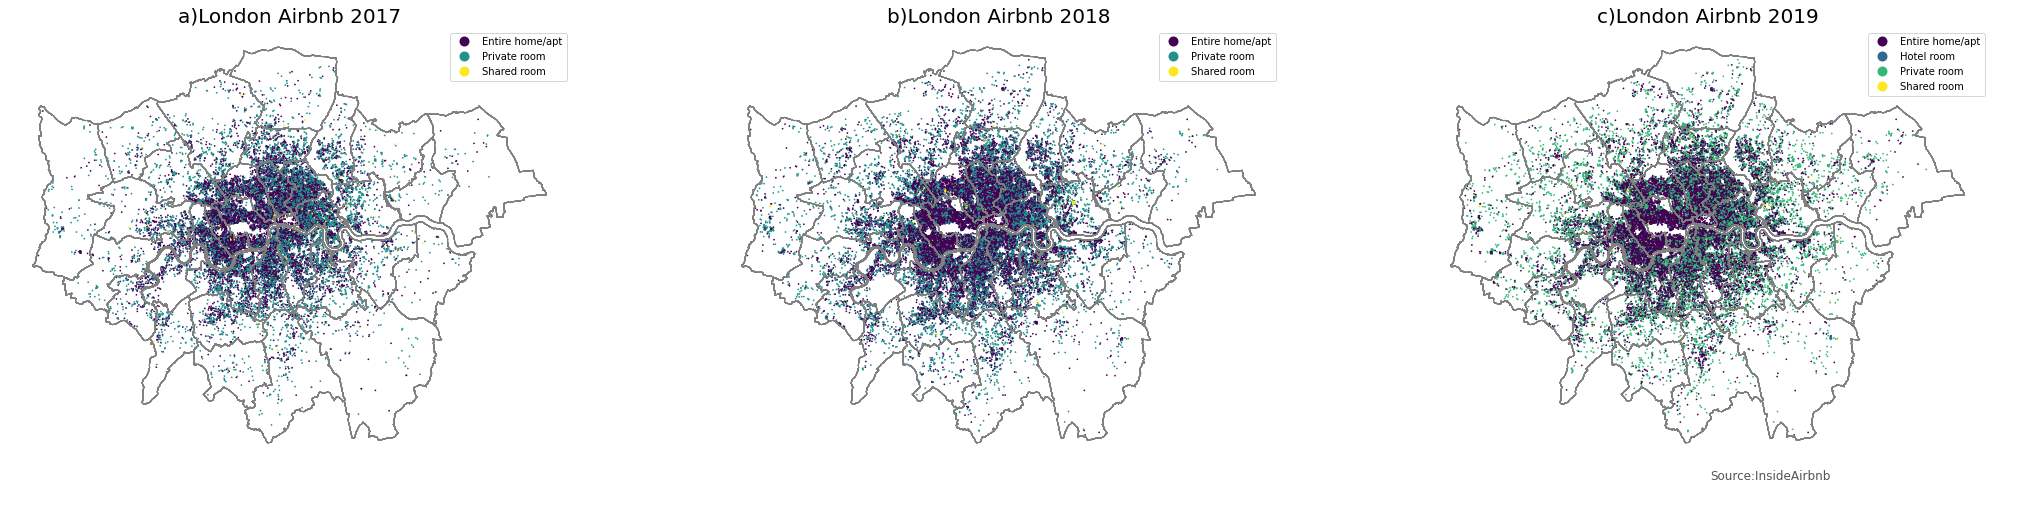

In [520]:
# visualise the airbnb points and the london map
f,ax=plt.subplots(1,3,figsize=(36,8))

point2017.plot(ax=ax[0],column='room_type',cmap='viridis',markersize=0.5,legend=True)
point2018.plot(ax=ax[1],column='room_type',cmap='viridis',markersize=0.5,legend=True)
point2019.plot(ax=ax[2],column='room_type',cmap='viridis',markersize=0.5,legend=True)

for i in [0,1,2]:
    wards_merge.plot(ax=ax[i],facecolor='none',edgecolor="gray")
    ax[i].axis('off')
    
ax[0].set_title('a)London Airbnb 2017', fontdict={'fontsize':'20', 'fontweight':'3'}) 
ax[1].set_title('b)London Airbnb 2018', fontdict={'fontsize':'20', 'fontweight':'3'}) 
ax[2].set_title('c)London Airbnb 2019', fontdict={'fontsize':'20', 'fontweight':'3'}) 

ax[1].annotate('Source:InsideAirbnb',xy=(0.905, 0.055), xycoords='figure fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=12, fontweight=4, color='#555555').set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))

f.savefig('Figure 1 The Distribution of Airbnbs in London.png', dpi=300)

In [521]:
# check the max and min
b=2017
for i in [wards_merge.counts_airbnb_2017.values,wards_merge.counts_airbnb_2018.values,wards_merge.counts_airbnb_2019.values]:
    print(f'The maximum value in {b} is {max(i)}')
    print(f'The minimum value in {b} is {min(i)}')
    print( )
    b=b+1

The maximum value in 2017 is 2984.0
The minimum value in 2017 is 32.0

The maximum value in 2018 is 5010.0
The minimum value in 2018 is 80.0

The maximum value in 2019 is 5721.0
The minimum value in 2019 is 91.0



In [525]:
def get_max_info(m):
    return wards_merge[wards_merge[m].values==max(wards_merge[m].values)].head(1)
def get_min_info(m):
    return wards_merge[wards_merge[m].values==min(wards_merge[m].values)].head(1)

In [526]:
# use the function to get the detialed information
get_max_info('counts_airbnb_2017')

,NAME,Code,HECTARES,NONLD_AREA,ONS_INNER,geometry,counts_airbnb_2017,counts_airbnb_2018,counts_airbnb_2019,Count_2017,...,Count_2018,Average_2018,Count_2019,Average_2019,air1718,air1819,rent_count1718,rent_count1819,rent_price1718,rent_price1819
384,Westminster,E09000033,2203.005,54.308,T,"MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...",2984.0,5010.0,5721.0,4130.0,...,2710.0,2784.0,3190.0,2832.0,2026.0,711.0,-1420.0,480.0,0.0,48.0


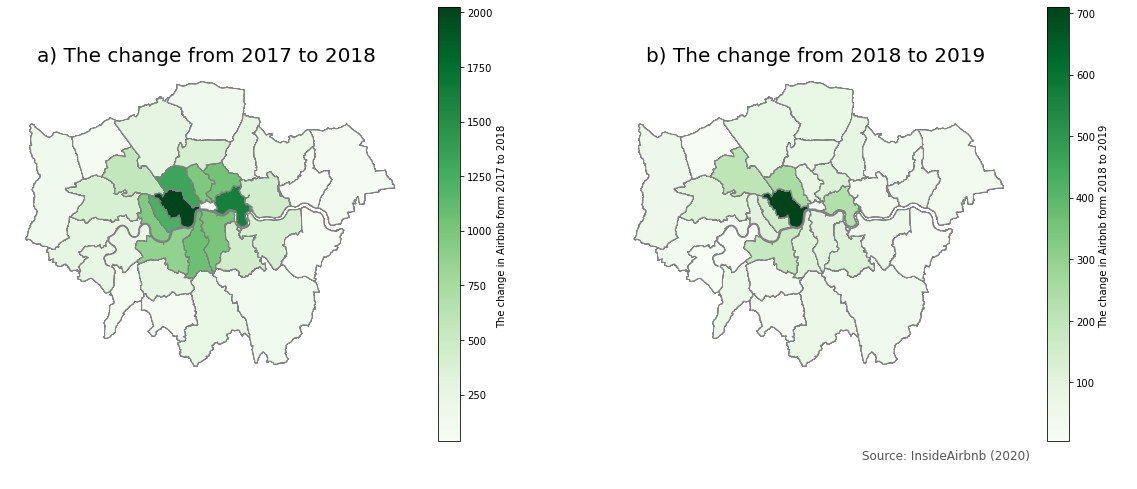

In [527]:
# polt the change
f,ax=plt.subplots(1,2,figsize=(20,8))

wards_merge.plot(ax=ax[0],column='air1718',cmap = plt.cm.Greens,edgecolor="gray",
                 legend=True,legend_kwds={'label':'The change in Airbnb form 2017 to 2018 '},zorder=0)
ax[0].set_title('a) The change from 2017 to 2018 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

wards_merge.plot(ax=ax[1],column='air1819',cmap = plt.cm.Greens,edgecolor="gray",legend=True,
                 legend_kwds={'label':'The change in Airbnb form 2018 to 2019 '},zorder=0)
ax[1].set_title('b) The change from 2018 to 2019 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

ax[1].annotate('Source: InsideAirbnb (2020)',xy=(0.905, 0.055), xycoords='figure fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=12, fontweight=4, color='#555555').set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))

ax[0].axis('off')
ax[1].axis('off')

f.savefig('Figure 2 The change of Airbnbs in London.png', dpi=300)

In [528]:
# check the max and min
for i in [wards_merge.air1718.values,wards_merge.air1819.values]:
    print(f'The maximum value is {max(i)}')
    print(f'The minimum value is {min(i)}')
    print( )

The maximum value is 2026.0
The minimum value is 36.0

The maximum value is 711.0
The minimum value is 4.0



In [529]:
get_max_info('air1718')

,NAME,Code,HECTARES,NONLD_AREA,ONS_INNER,geometry,counts_airbnb_2017,counts_airbnb_2018,counts_airbnb_2019,Count_2017,...,Count_2018,Average_2018,Count_2019,Average_2019,air1718,air1819,rent_count1718,rent_count1819,rent_price1718,rent_price1819
384,Westminster,E09000033,2203.005,54.308,T,"MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...",2984.0,5010.0,5721.0,4130.0,...,2710.0,2784.0,3190.0,2832.0,2026.0,711.0,-1420.0,480.0,0.0,48.0


##### 4.2 Impact on the numbers of private rents

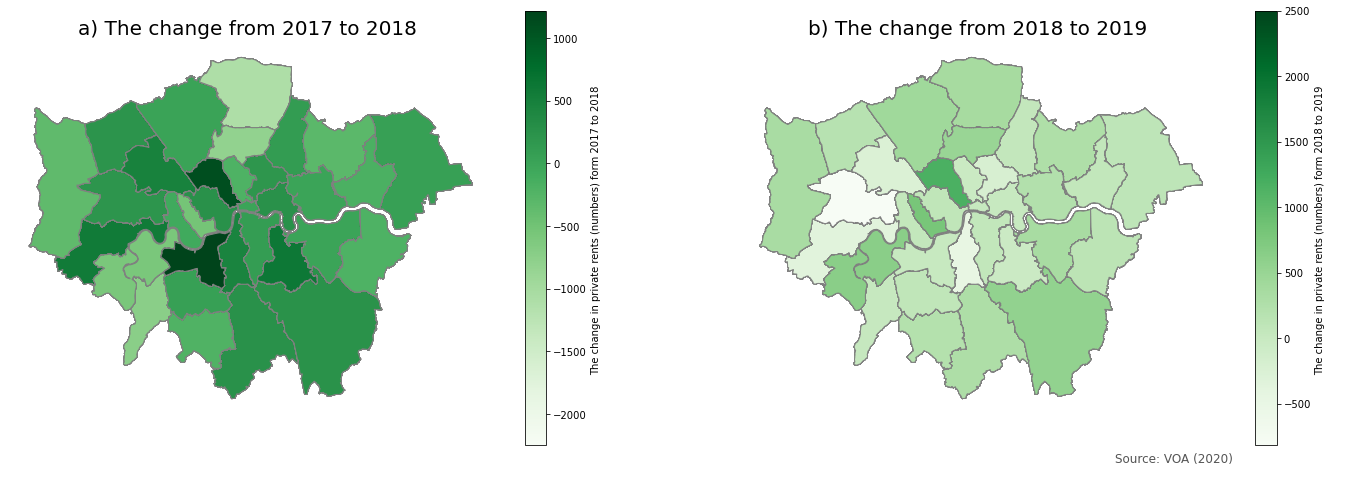

In [530]:
f,ax=plt.subplots(1,2,figsize=(24,8))

wards_merge.plot(ax=ax[0],column='rent_count1718',cmap = plt.cm.Greens,edgecolor="gray",legend=True,legend_kwds={'label':'The change in private rents (numbers) form 2017 to 2018 '})
ax[0].set_title('a) The change from 2017 to 2018 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

wards_merge.plot(ax=ax[1],column='rent_count1819',cmap = plt.cm.Greens,edgecolor="gray",legend=True,legend_kwds={'label':'The change in private rents (numbers) form 2018 to 2019 '})
ax[1].set_title('b) The change from 2018 to 2019 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

ax[1].annotate('Source: VOA (2020)',xy=(0.905, 0.055), xycoords='figure fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=12, fontweight=4, color='#555555').set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))

ax[0].axis('off')
ax[1].axis('off')

f.savefig('Figure 3 The change of the numbers of rents in London.png', dpi=300)

In [531]:
# print the mean values
print(f'The mean of the numbers of private rents in 2017 is {np.mean(wards_merge.Count_2017.values)}.')
print(f'The mean of the numbers of private rents in 2018 is {np.mean(wards_merge.Count_2018.values)}.')
print(f'The mean of the numbers of private rents in 2019 is {np.mean(wards_merge.Count_2019.values)}.')
print(f'The average increasd numbers of private rents from 2017 to 2018 is {np.mean(wards_merge.rent_count1718.values)}.')
print(f'The average increasd numbers of private rents from 2018 to 2019 is {np.mean(wards_merge.rent_count1819.values)}.')

The mean of the numbers of private rents in 2017 is 1820.1515151515152.
The mean of the numbers of private rents in 2018 is 1676.6666666666667.
The mean of the numbers of private rents in 2019 is 1872.4242424242425.
The average increasd numbers of private rents from 2017 to 2018 is -143.4848484848485.
The average increasd numbers of private rents from 2018 to 2019 is 195.75757575757575.


In [532]:
# add three more variables for regression analysis
calculation2=pd.DataFrame({'Code':[],'air1719':[],'rent_count1719':[],'rent_price1719':[]})
calculation2.Code=wards_merge.Code
calculation2.air1719=wards_merge.counts_airbnb_2019-wards_merge.counts_airbnb_2017
calculation2.rent_count1719=wards_merge.Count_2019-wards_merge.Count_2017
calculation2.rent_price1719=wards_merge.Average_2019-wards_merge.Average_2017
wards_merge = wards_merge.merge(calculation2,on='Code', how = 'left')

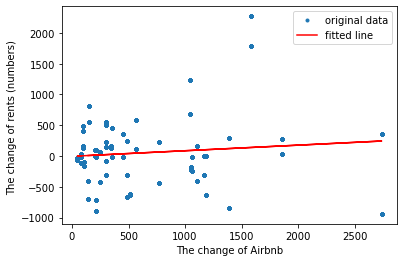

y = 0.091 x + -4.612
Rsq =  0.010305116420928224
p-value =  8.498982457557921e-21


In [533]:
X = wards_merge.air1719
Y = wards_merge.rent_count1719

plt.xlabel('The change of Airbnb')
plt.ylabel('The change of rents (numbers) ')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.

plt.legend()
plt.show()

print("y =", round(slope,3), "x +", round(intercept,3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

##### 4.3 Impact on the prices of rent

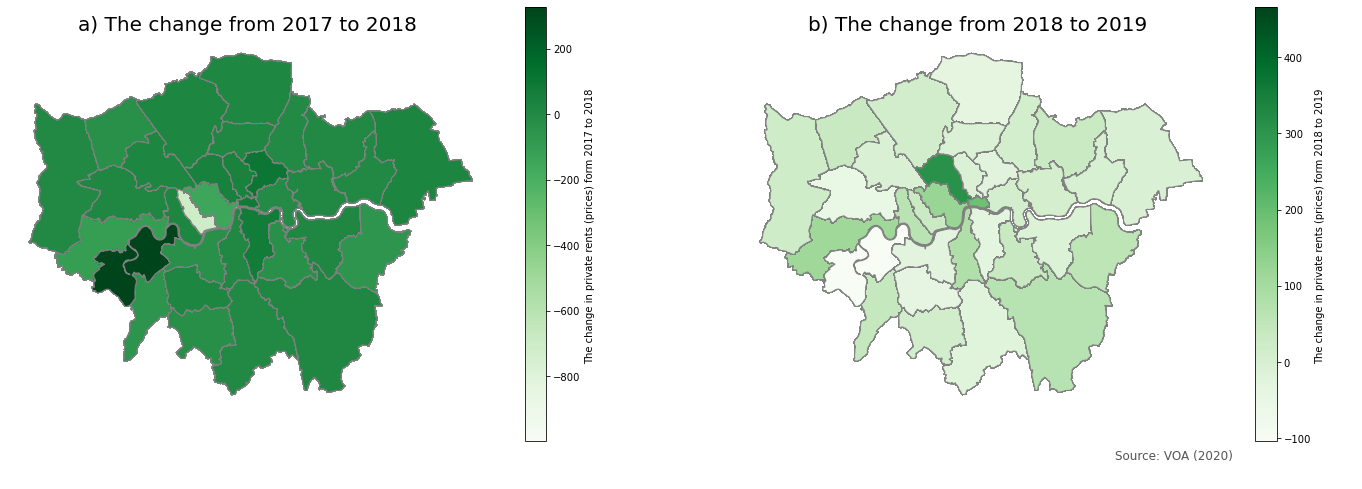

In [534]:
f,ax=plt.subplots(1,2,figsize=(24,8))

wards_merge.plot(ax=ax[0],column='rent_price1718',cmap = plt.cm.Greens,edgecolor="gray",legend=True,legend_kwds={'label':'The change in private rents (prices) form 2017 to 2018 '})
ax[0].set_title('a) The change from 2017 to 2018 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

wards_merge.plot(ax=ax[1],column='rent_price1819',cmap = plt.cm.Greens,edgecolor="gray",legend=True,legend_kwds={'label':'The change in private rents (prices) form 2018 to 2019 '})
ax[1].set_title('b) The change from 2018 to 2019 ', fontdict={'fontsize':'20', 'fontweight':'3'}) 

ax[1].annotate('Source: VOA (2020)',xy=(0.905, 0.055), xycoords='figure fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=12, fontweight=4, color='#555555').set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))

ax[0].axis('off')
ax[1].axis('off')

f.savefig('Figure 4 The change of the price of rents in London.png', dpi=300)

In [536]:
# print the mean values
print(f'The mean price of private rents in 2017 is {np.mean(wards_merge.Average_2017.values)}.')
print(f'The mean price of private rents in 2018 is {np.mean(wards_merge.Average_2018.values)}.')
print(f'The mean price of private rents in 2019 is {np.mean(wards_merge.Average_2019.values)}.')
print(f'The average increasd price of private rents from 2017 to 2018 is {np.mean(wards_merge.rent_price1718.values)}.')
print(f'The average increasd price of private rents from 2018 to 2019 is {np.mean(wards_merge.rent_price1819.values)}.')

The mean price of private rents in 2017 is 1614.5151515151515.
The mean price of private rents in 2018 is 1584.5151515151515.
The mean price of private rents in 2019 is 1628.2121212121212.
The average increasd price of private rents from 2017 to 2018 is -30.0.
The average increasd price of private rents from 2018 to 2019 is 43.696969696969695.


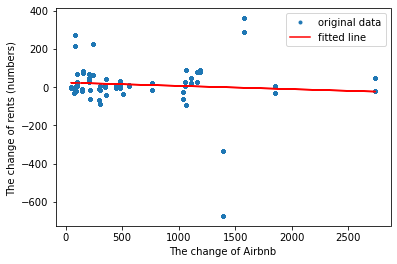

y = -0.017 x + 24.498
Rsq =  0.006947876589728969
p-value =  1.673242396920178e-14


In [535]:
X = wards_merge.air1719
Y = wards_merge.rent_price1719

plt.xlabel('The change of Airbnb')
plt.ylabel('The change of rents (numbers) ')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.

plt.legend()
plt.show()

print("y =", round(slope,3), "x +", round(intercept,3))
print("Rsq = ", r_value**2)
print("p-value = ", p_value)

# Executive Briefing

## Executive Summary
As London's largest short-term rental platform, Airbnb is considered a "disruptive innovation." But with its rise, there are more and more voices against it, because Airbnb may have a negative impact on the traditional tourism industry, the hotel industry, and the local long-term rental market.

This report provides a comprehensive analysis of the London Airbnb activity and private rental market in the past three years (2017, 2018 and 2019). The report mainly answers three questions:

1 Where is Airbnb listings located, and how is it changing?

2 How does Airbnb affect the number of private rents?

3 How does Airbnb affect the price of private rents?

key findings
- Westminster is the place where Airbnb activities are most concentrated. It the most listings (reached 5721 in 2019), and the number has been increasing.

- Although the number of Airbnb in Westminster increased, the local rental market is not affected much-the average rent did not increase.

- The number of Airbnb in Richmond upon Thames increased less, but the average price of the rent increased the most (329 £/y from 2017 to 2019).

- Camden and Wandsworth have increased the number of private rents, but they have also relatively high increased number of Airbnb. It shows that the rental market of these two boroughs is not greatly affected by Airbnb.

- There are other factors that also affect the leasing market. The regression coefficients of Airbnb growth and rental prices and numbers are not consistent with expectations.

- Different regions are affected differently by Airbnb, and different regulatory policies need to be adopted for different regions.

## Introduction
Short-term rental is a kind of flexible accommodation which is popular with tourists and holidaymakers from all over the world. In London, short-term rental platforms mainly include Airbnb, Booking.com, TripAdvisor and HomeAway, while Airbnb is the largest platform in London, accounting for 65% of the market. Airbnb basically does not own real estate; instead, it collects fees by acting as an intermediary between the host and the person who wants to book short-term accommodation(Bivens, 2019).

Airbnb is considered a "disruptive innovation" (Christensen and Raynor, 2013), because of its innovative Internet-based business model and its unique attraction to tourists. However, Airbnb is potentially destructive at the same time. Its rise has had many major impacts, including traditional tourism (Guttentag, 2015), unfair competition in the hotel industry(Zervas et al., 2017), local government taxes(Dalir et al., 2020), and local residents’ externalities(Nieuwland and Van Melik, 2020). In addition to these impacts, the government is also concerned that it may have a negative impact on the local long-term lease market. When hosts find it more profitable to run an Airbnb business, they may evict long-term tenants(Ayouba et al., 2020). Therefore, the impact of the increase in the number of Airbnb on the local housing rental market cannot be ignored.



## 1 Where is Airbnb listings located, and how is it changing?
The distribution of Airbnb (Figure 1) is mainly concentrated in inner London. The borough with the most Airbnb listings is Westminster, which has 2984, 5010 and 5721 listings in 2017, 2018 and 2019, respectively. In the past few years, the number of London Airbnb listings has increased from 27305 in 2017 to 48011 in 2019, which has nearly doubled. This further illustrates the rise and popularity of Airbnb in recent years. Figure 2 shows in which boroughs these increases are more significant. Among the two time periods, the borough with the largest increase was Westminster, where the number increased by 2026 and 711 respectively. It further illustrates that Westminster is the most concentrated place for Airbnb activities.

In these three years, the boroughs with the least number of Airbnb are Havering (32 in 2017) and Bexley (80 in 2018 and 91 in 2019). The boroughs with the least number of Airbnb growth are Bexley (36 from 2017 to 2018) and Richmond upon Thames (4 from 2018 to 2019). None of the boroughs showed negative values in these two growth cycles.

![figure1](https://raw.githubusercontent.com/akiakutaji/i2p_assessment/main/Assessment3/Figure/Figure%201%20The%20Distribution%20of%20Airbnbs%20in%20London.png)
<center> Figure 1 The Distribution of Airbnbs in London </center>

![figure2](https://github.com/akiakutaji/i2p_assessment/blob/main/Assessment3/Figure/Figure%202%20The%20change%20of%20Airbnbs%20in%20London.png?raw=true)
<center> Figure 2 The change of Airbnbs in London </center>

## 2 How does Airbnb affect the number of private rents?

When landlords find that Airbnb can make more money, they may evict their long-term tenants and invest in Airbnb operations. When this happens, as the number of Airbnb increases, theoretically the number of private rents would decline. According to analysis and calculation, the mean value of the numbers of private rents experienced a decline and then an increase (1820, 1677 and 1872, respectively). From the spatial distribution point of view (Figure 3), the increase is mainly concentrated in Camden and Wandsworth. The proportions of Airbnb growth in these two cities during 2017-2019 were 1578.0 and 1042.0, accounting for 7.6% and 5.03% of the total growth, ranking third and tenth, respectively. The number of Airbnb listings in Camden is growing relatively fast among all boroughs, so theoretically, the number of private rents should decline or the growth should be relatively slow. It shows that this borough is less affected by Airbnb. Admittedly, there may also be some other factors contributing to the large increase in the number of private rents in this area. For example, the local infrastructure had perfected and attracted many people.

Analyzing the correlation between the increasing number of Airbnb and the increasing number of private rents, it is found that the regression coefficient is 0.091, indicating that the growth of Airbnb is accompanied by a slight increase in the number of private rents. The reason for this may be that different boroughs are affected differently by Airbnb. Admittedly, it may also be caused by other reasons, such as an increase in the number of immigrants.

![figure3](https://github.com/akiakutaji/i2p_assessment/blob/main/Assessment3/Figure/Figure%203%20The%20change%20of%20the%20numbers%20of%20rents%20in%20London.png?raw=true)
<center> Figure 3 The change of the numbers of rents in London </center>


## 3 How does Airbnb affect the price of private rents?

Long-term renters facing rising house prices are considered a potential cost of Airbnb's development (Bivens, 2019). According to the rental price statistics of private rents in London, it is found that the average rents in the past three years were 1614.51 £/y, 1584.51 £/y, and 1628.21 £/y, which means, from 2017 to 2018, although the overall number of Airbnb listings has increased, the private rental price in London has decreased by 30 £/y instead. The reason for this may be that some boroughs did not be influenced of Airbnb, or the influence was not great. From Figure 4a, in Richmond upon Thames, the average price of the rent increased the most, with an increase of 329 £/y, but the area only increased by 240 Airbnb. Compared with Westminster's 2026 Airbnb growth over the same period, 240 are not many. While although Westminster increased by 2,026 Airbnb during this period, the average rent did not increase. This shows that the Richmond upon Thames area is more affected by Airbnb than Westminster.

According to the regression analysis of the increasing number of Airbnb and the increasing average rental price, the correlation coefficient is -0.017, indicating that, overall, the increase in the number of Airbnb and the increase in average rental housing are negatively correlated. In other words, with the increase in the number of Airbnb, the price of rental housing declined slightly. The reason for the result that is contrary to previous researches about Airbnb may be that there are some boroughs that are less affected by Airbnb. Another reason is that there are other possible causes that led to the decline in rents, such as the decline in national consumption levels.

![figure4](https://github.com/akiakutaji/i2p_assessment/blob/main/Assessment3/Figure/Figure%204%20The%20change%20of%20the%20price%20of%20rents%20in%20London.png?raw=true)
<center> Figure 4 The change of the price of rents in London </center>

## Conclusion and discussion: Different policies should be adopted for different regions

From the above analysis and discussion, there are some findings as follows. (1) Westminster is the place where Airbnb activities are most concentrated. It the most listings (reached 5721 in 2019), and the number has been increasing. (2) Although the number of Airbnb in Westminster increased, the local rental market is not affected much-the average rent did not increase. (3) The number of Airbnb in Richmond upon Thames increased less, but the average price of the rent increased the most (329 £/y from 2017 to 2019). (4) Camden and Wandsworth have increased the number of private rents, but they have also relatively high increased number of Airbnb. It shows that the rental market of these two boroughs is not greatly affected by Airbnb. (5) There are other factors that also affect the leasing market. The regression coefficients of Airbnb growth and rental prices and numbers are not consistent with expectations.

Currently, Airbnb is becoming commercialized against its original intention, and many hosts have multiple listings. Considering the potential costs of its development, government regulation is necessary (Bivens, 2019). The current policies are formulated and implemented with the whole London as a unit, such as the 90-day rule. While from the above analysis, in the rental market, different boroughs have different sensitivity to Airbnb. Considering the potential benefits that Airbnb can also bring at the same time, (for example, homestays with local characteristics can attract tourists to live in, and then to promote the development of tourism), the one-size-fits-all policy is too arbitrary. For instance, there may be a resident who needs to live in inner London all year round because of his work, and he owns a house in outer London which is very close to a scenic area. This person can completely rent his house on the Airbnb platform for a short-term rental to get an extra income (also to subsidize his rent in inner London). Under such circumstances, the 90-day rule can only play a negative role, both for the residents or the development of tourism in the area. Therefore, it is most effective to formulate different policies for different regions. For example, Richmond upon Thames has more tourists, and Airbnb's policy can be appropriately relaxed.


## Reference
AYOUBA, K., BREUILLE, M.-L., GRIVAULT, C. & LE GALLO, J. J. I. R. S. R. 2020. Does Airbnb disrupt the private rental market? An empirical analysis for French cities. 43, 76-104.

BIVENS, J. 2019. The economic costs and benefits of Airbnb. Economic Policy Institute.

CHRISTENSEN, C. & RAYNOR, M. 2013. The innovator's solution: Creating and sustaining successful growth, Harvard Business Review Press.

DALIR, S., MAHAMADAMINOV, A. & OLYA, H. G. J. T. E. 2020. Airbnb and taxation: Developing a seasonal tax system. 1354816620904894.

GUTTENTAG, D. J. C. I. I. T. 2015. Airbnb: disruptive innovation and the rise of an informal tourism accommodation sector. 18, 1192-1217.

NIEUWLAND, S. & VAN MELIK, R. J. C. I. I. T. 2020. Regulating Airbnb: how cities deal with perceived negative externalities of short-term rentals. 23, 811-825.

ZERVAS, G., PROSERPIO, D. & BYERS, J. W. J. J. O. M. R. 2017. The rise of the sharing economy: Estimating the impact of Airbnb on the hotel industry. 54, 687-705.
